# <center>Side Radar Analysis from 10-14-2022 data</center>
<center>Jonathan Sprinkle, Matt Nice</center>
<center>Vanderbilt University</center>

Instructions for use:
1. Replace the base folders to match the descriptions of where your files are
1. Modify the name of the data file(s) you are using
1. Press Run to see the basic data values plotted in a single instance

Advanced properties:
1. Establish the time difference between dashcam (if any) and the data timestamps


## Preliminary things to do
1. clone strym somewhere on your computer: `cd strym_location && git clone https://github.com/jmscslgroup/strym.git`
1. get the datafile(s) from cyverse: `cd nissan_test_folder && irsync -r -v i:/iplant/home/mnice/nissan_test .`

In [99]:
import numpy as np
import matplotlib.pyplot as pt
import csv
import pandas as pd
import cantools 
import matplotlib.animation as animation
from matplotlib import style
from haversine import haversine, Unit
import time
import strym as s
from strym import strymread
from datetime import datetime
import math

%config IPKernelApp.matplotlib = 'inline'
%config InlineBackend.figure_format ='retina'

nissan_test_folder='/Users/sprinkle/work/data/nissan_test/minitest_side_radar_calibration/'

strym_location='/Users/sprinkle/work/research/circles/strym-dev/'
dbc_folder=strym_location+'strym/dbc/'

# load the dbc file for later use
dbcfile=dbc_folder + 'nissan_rogue_2021.dbc'
db = cantools.database.Database()
with open(dbcfile,'r') as fin:
    db = cantools.database.load(fin)

In [121]:
# list your datafiles you plan to use
datafile = '2022-10-14-15-27-30_JN8AT3CB9MW240939_CAN_Messages.csv'
# datafile_side = '2022-09-19-19-17-31_JN8AT3CB9MW240939_CAN_Messages.csv'

## Load boilerplate code that will be used often

In [116]:
def getUnixTimeFromTimestamp(date_string):
    """Input string formatted as %Y-%m-%d %H:%M:%S"""
    from datetime import datetime
    myUnixTime = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
#     result = datetime.utcfromtimestamp(myUnixTime.strftime('%Y-%m-%d %H:%M:%S'))
#     result = myUnixTime.timestamp()
    result = myUnixTime.timestamp() - 6*3600

    return result

# a function that overlays timed events on an existing plot
def overlayEvents( ax, redEvents, blueEvents, grayEvents, fudgeFactor=0, relativeTime=0 ):
    """Pass in the axis of a figure. Event are arrays of times to be put on the """
    for ev in redEvents:
        ax.axvline(ev+fudgeFactor-relativeTime,0,1,color='red')
    for ev in blueEvents:
        ax.axvline(ev+fudgeFactor-relativeTime,0,1,color='blue')
    for ev in grayEvents:
        ax.axvline(ev+fudgeFactor-relativeTime,0,1,color='gray')

def getMinicarChanges(minicar_data):
    """Returns a tuple of times when minicar changes take place. 
    
    The input is a dataframe subset of decoded minicar signals.
    
    The values returned appearances: times when the minicar goes from off to on
    disapperances: times when the minicar goes from on to off """
    result = []
    states = strymread.create_chunks(data, column_of_interest='Message',continuous_threshold=0.5)
    for mc in states:
        if mc.iloc[0].Message == 0:
            continue
        elif mc.iloc[0].Message == 1:
            start = mc.iloc[0].Time
            end = mc.iloc[-1].Time
#             print('State runs from ', start, ' to ', end)
            if data.iloc[0].Time == start:
#                 print('skipping first instance')
                continue
            elif data.iloc[-1].Time == end:
#                 print('skipping last instance')
                continue
            else:
                result.append([start,end])
#         else:
#             print('oops')

    return result

def getTimeWindow(data, t0 = None, t1 = None, relative = False):
    """Return the time window dataframe that is between (and including if applicable) [t0, t1]"""
    if relative == True:
        if t0:
            t0 = data.iloc[1].Time + t0
        if t1:
            t1 = data.iloc[1].Time + t1
    if t0:
        data = data.loc[data.Time >= t0]
    if t1:
        data = data.loc[data.Time <= t1]
    return data


# Load the data

In [122]:
dataframe = pd.read_csv(nissan_test_folder+'/'+datafile)
dataframe_side = dataframe

In [144]:
# list important times that are gathered from dashcam information
# once more with more information to validate across a longer time horizon
start_pass = []
end_pass = []
cutin = []

start = getUnixTimeFromTimestamp('2022-10-14 16:27:59') 
cutin.append(getUnixTimeFromTimestamp('2022-10-14 16:28:14')) # put car in reverse to move

start_pass.append(getUnixTimeFromTimestamp('2022-10-14 16:29:22')) # 10mph starting to pass
end_pass.append(getUnixTimeFromTimestamp('2022-10-14 16:29:33')) # 10mph passed all cars

start_pass.append(getUnixTimeFromTimestamp('2022-10-14 16:30:14')) # 15mph start
end_pass.append(getUnixTimeFromTimestamp('2022-10-14 16:30:24')) # 15mph end

start_pass.append(getUnixTimeFromTimestamp('2022-10-14 16:31:20')) # 20mph start
end_pass.append(getUnixTimeFromTimestamp('2022-10-14 16:31:27')) # 20mph end


end = getUnixTimeFromTimestamp('2022-10-14 16:31:51') + 10

# text of start/end times
start_txt = datetime.utcfromtimestamp(start).strftime('%H:%M:%S')
end_txt = datetime.utcfromtimestamp(end).strftime('%H:%M:%S')

# videoFudgeFactor: difference between time for video, and time for the rpi
videoFudgeFactor=1.2

print('Video timestamps should run from ', start_txt,' to ', end_txt, 
      ', and will be approximately', videoFudgeFactor, 's behind the CAN data.')

Video timestamps should run from  15:27:59  to  15:32:01 , and will be approximately 1.2 s behind the CAN data.


In [131]:
dataframe_window = getTimeWindow(dataframe,start,end)

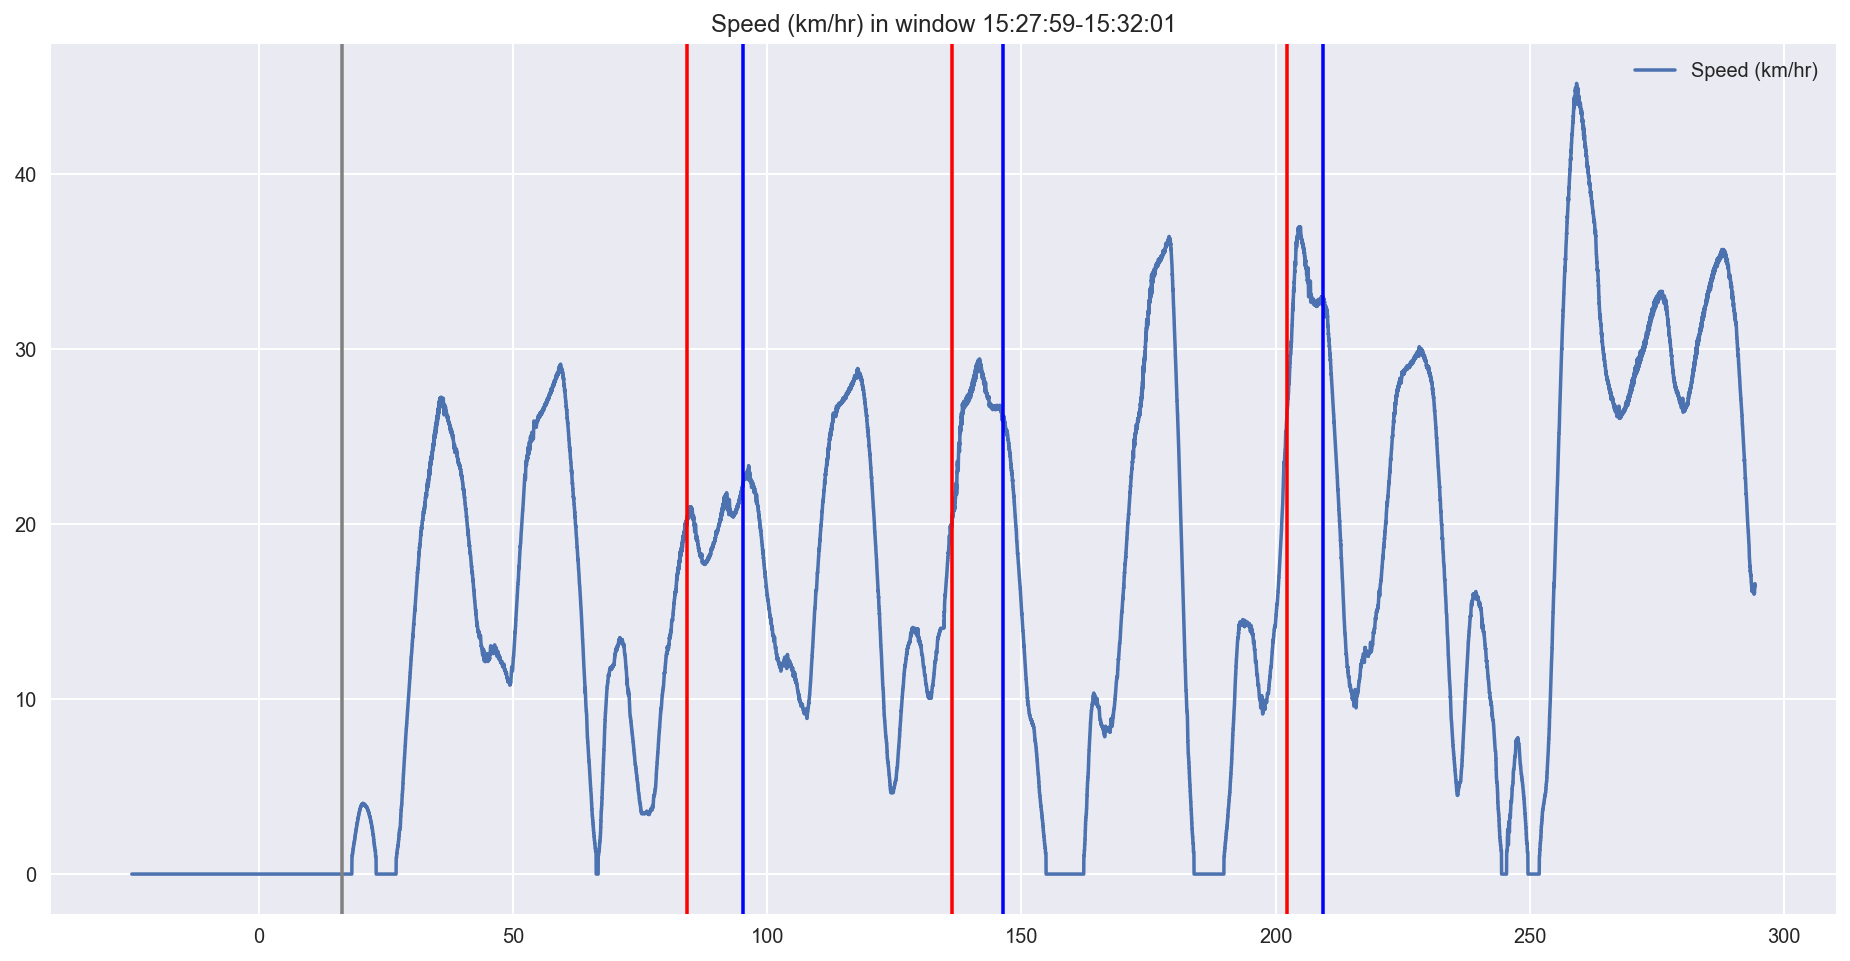

In [132]:
# now, we get and plot a bunch of stuff
speed = s.convertData('SPEED','SPEED',dataframe,db)
# subtract the start time to show relative time in the plot
pt.plot(speed.Time-start,speed.Message, label='Speed (km/hr)')
pt.title('Speed (km/hr) in window ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), start_pass, end_pass, cutin, fudgeFactor=videoFudgeFactor, relativeTime=start)

## Get side radar/sensor information into scope

In later drives, we'll be getting this information all in one CAN file, but for now we are needing to capture it in two different ones. So in order to have the other data side-by-side, we will read in and sample the other dataset in the same timeframe.

In [133]:
dataframe_side_window = getTimeWindow(dataframe_side,start,end)

In [134]:
dataframe_side_window

,Time,Bus,MessageID,Message,MessageLength
117004,1.665761e+09,0,168,0000a807ff402a09a0800000000050f9b4006c51a88e62c8,24.0
117005,1.665761e+09,2,168,0000a807ff402a09a0800000000050f9b4006c51a88e62c8,24.0
117006,1.665761e+09,1,168,0000a807ff402a09a0800000,12.0
117007,1.665761e+09,0,544,00022003b35b6000000050fa54d71394f2d29feb,20.0
117008,1.665761e+09,2,544,00022003b35b6000000050fa54d71394f2d29feb,20.0
...,...,...,...,...,...
1249870,1.665762e+09,1,888,9aa8c201fe0300ffffffff5fbcfffff85d8c7240ffffff...,32.0
1249871,1.665762e+09,0,139,000135084d20a7f800007d000001e002bb2000019a0820...,48.0
1249872,1.665762e+09,2,139,000135084d20a7f800007d000001e002bb2000019a0820...,48.0
1249873,1.665762e+09,0,534,00021604ab8820000000a67b39887adc67a5a80f,20.0


There are dozens or more side radar signals, we select a few of them below and try to indicate whether they are left or right.

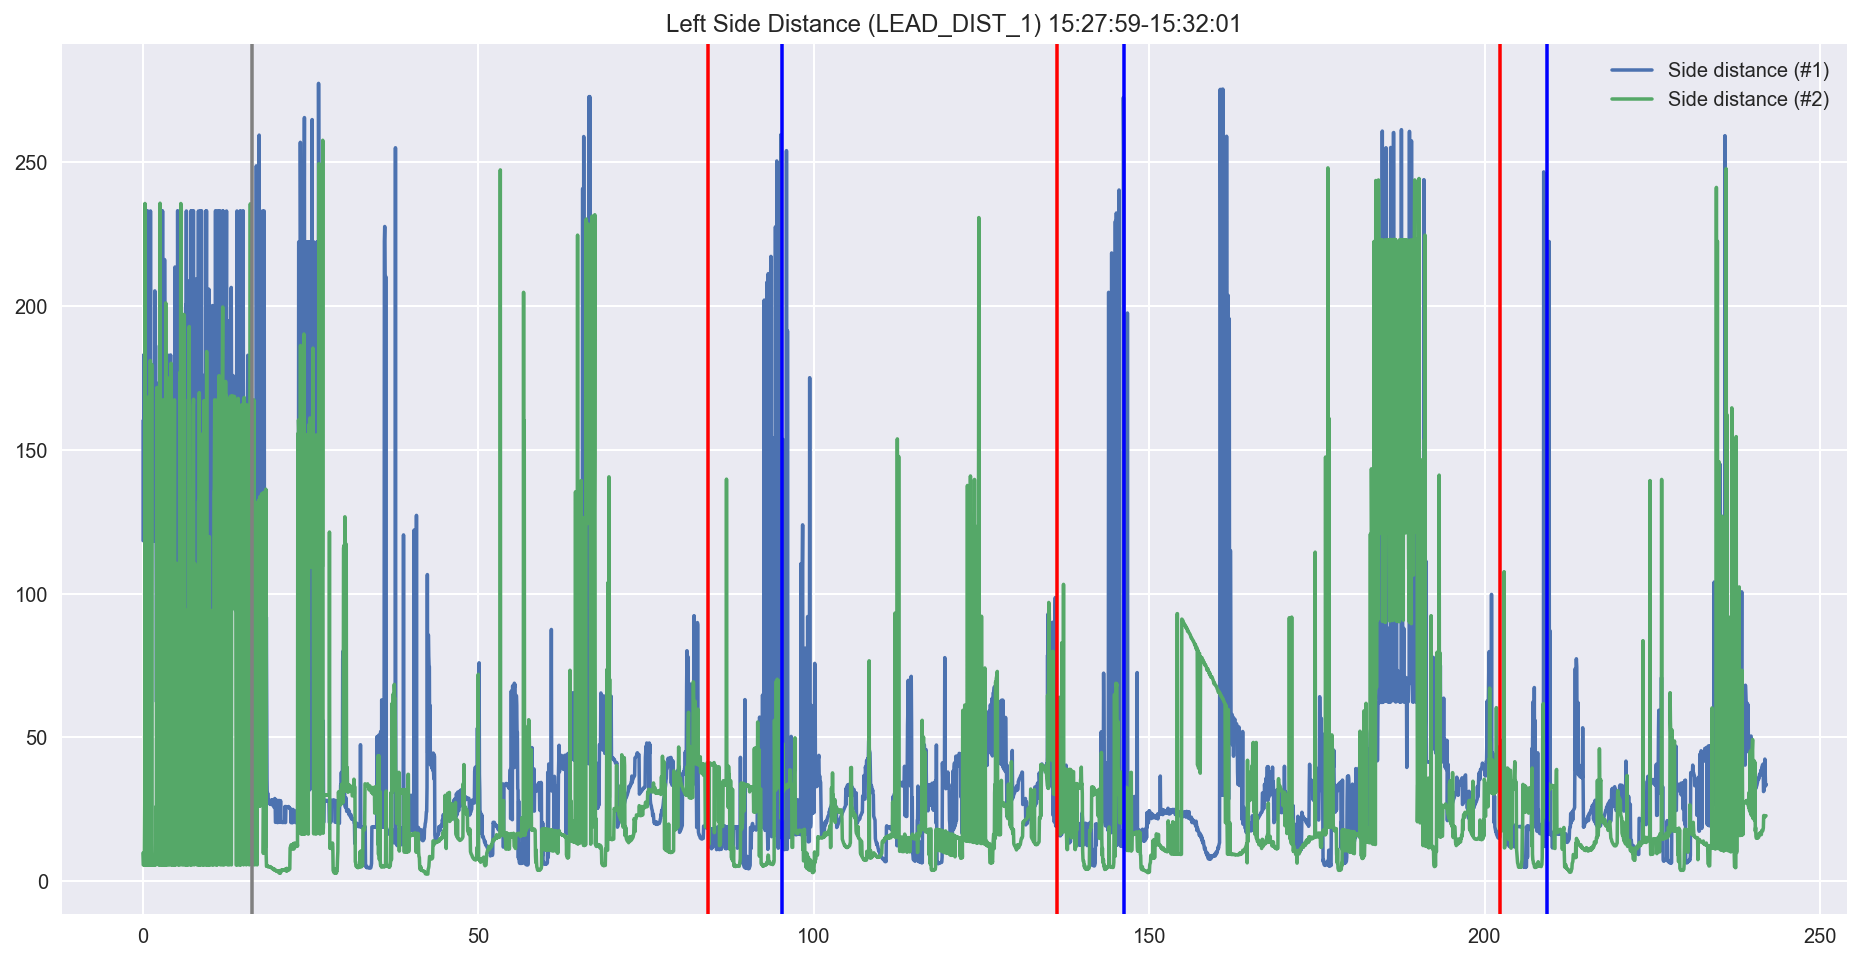

In [136]:
side_1 = s.convertData('RADAR_SENSOR1','LEAD_DIST1',dataframe_side_window,db)
pt.plot(side_1.Time-start,side_1.Message,label='Side distance (#1)')

side_2 = s.convertData('RADAR_SENSOR2','LEAD_DIST1',dataframe_side_window,db)
pt.plot(side_2.Time-start,side_2.Message,label='Side distance (#2)')

pt.title('Left Side Distance (LEAD_DIST_1) ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), start_pass, end_pass, cutin, 
              fudgeFactor=videoFudgeFactor, relativeTime=start)




# Look at each event differently

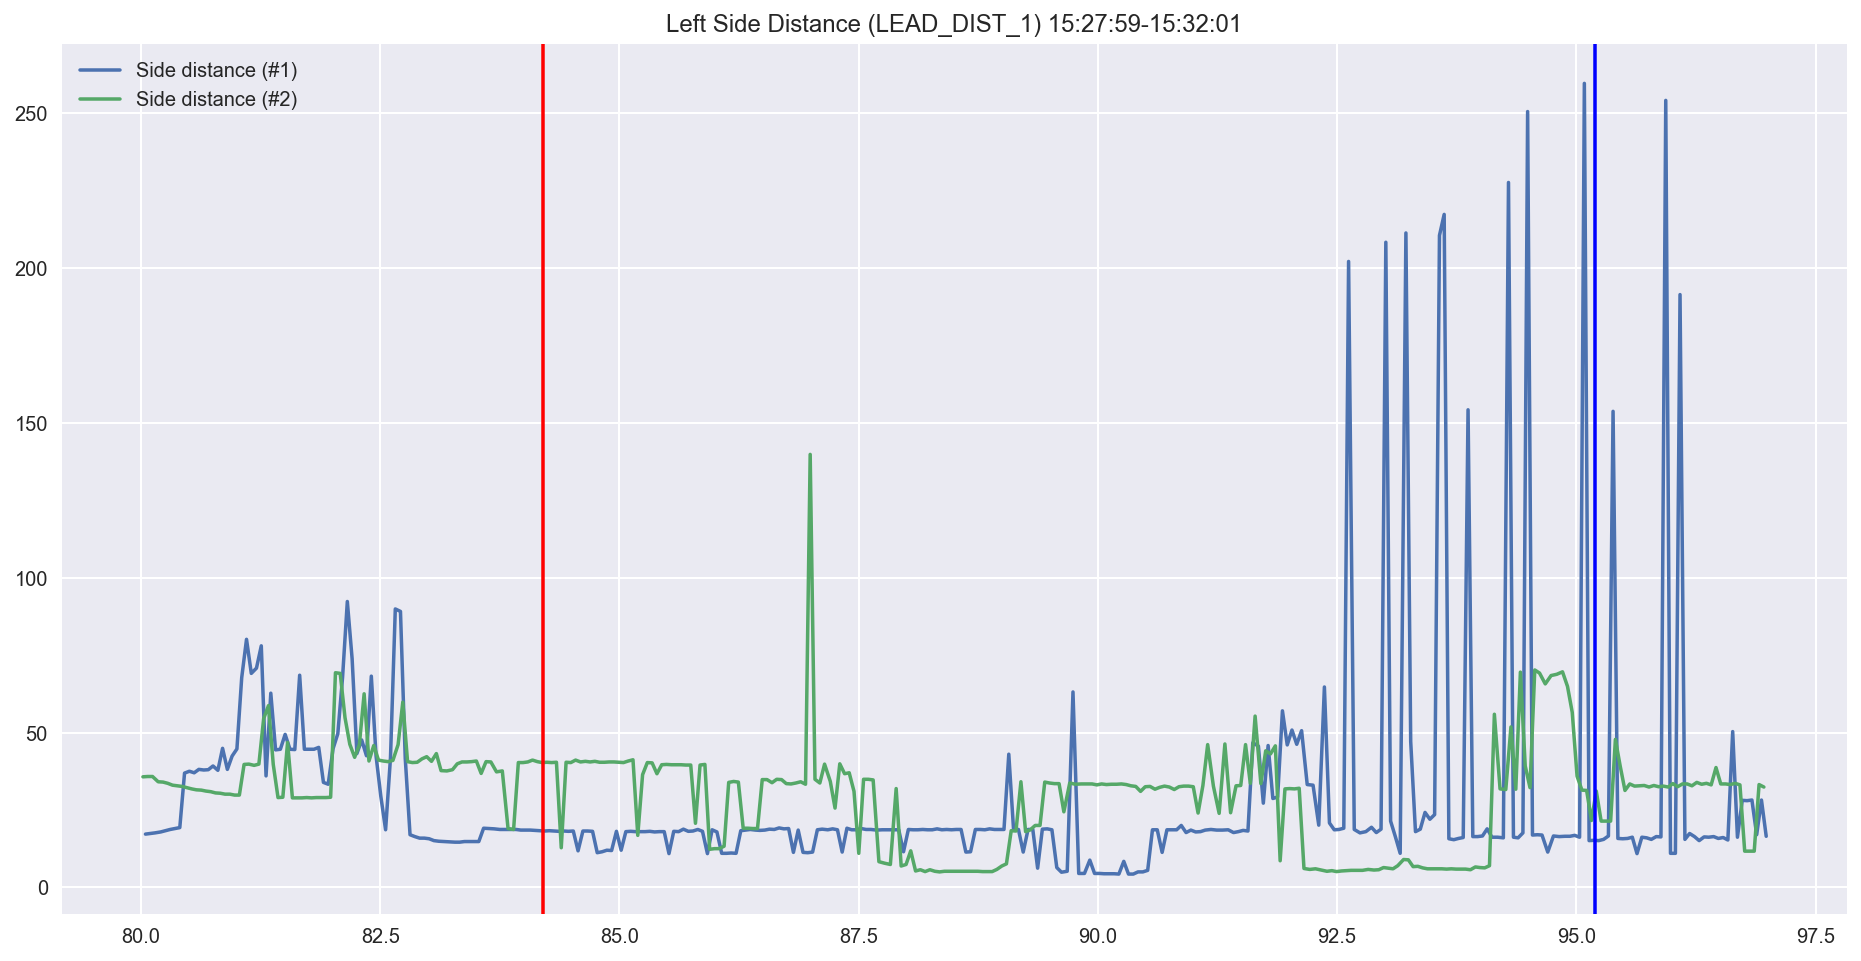

In [141]:
pass_number=0
dataframe_pass = getTimeWindow(dataframe_side,start_pass[pass_number]-3,end_pass[pass_number]+3)
side_1 = s.convertData('RADAR_SENSOR1','LEAD_DIST1',dataframe_pass,db)
pt.plot(side_1.Time-start,side_1.Message,label='Side distance (#1)')

side_2 = s.convertData('RADAR_SENSOR2','LEAD_DIST1',dataframe_pass,db)
pt.plot(side_2.Time-start,side_2.Message,label='Side distance (#2)')

pt.title('Left Side Distance (LEAD_DIST_1) ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), [start_pass[pass_number]], [end_pass[pass_number]], [], 
              fudgeFactor=videoFudgeFactor, relativeTime=start)




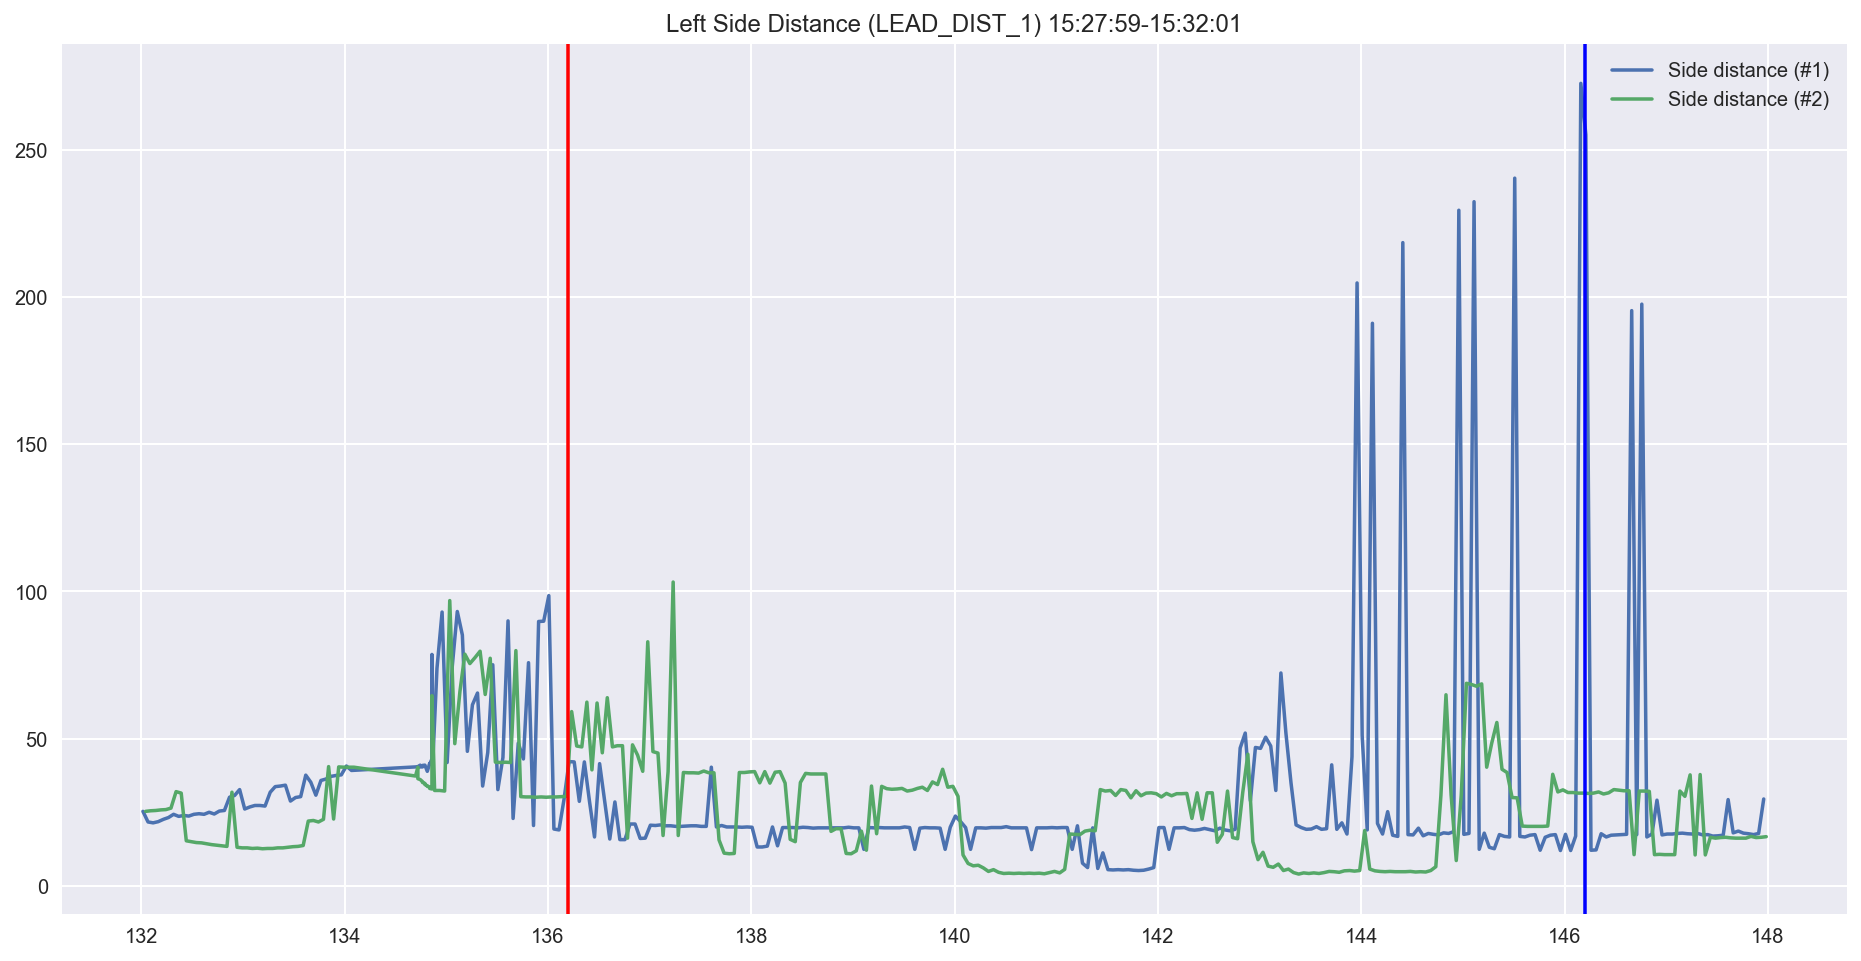

In [142]:
pass_number=1
dataframe_pass = getTimeWindow(dataframe_side,start_pass[pass_number]-3,end_pass[pass_number]+3)
side_1 = s.convertData('RADAR_SENSOR1','LEAD_DIST1',dataframe_pass,db)
pt.plot(side_1.Time-start,side_1.Message,label='Side distance (#1)')

side_2 = s.convertData('RADAR_SENSOR2','LEAD_DIST1',dataframe_pass,db)
pt.plot(side_2.Time-start,side_2.Message,label='Side distance (#2)')

pt.title('Left Side Distance (LEAD_DIST_1) ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), [start_pass[pass_number]], [end_pass[pass_number]], [], 
              fudgeFactor=videoFudgeFactor, relativeTime=start)




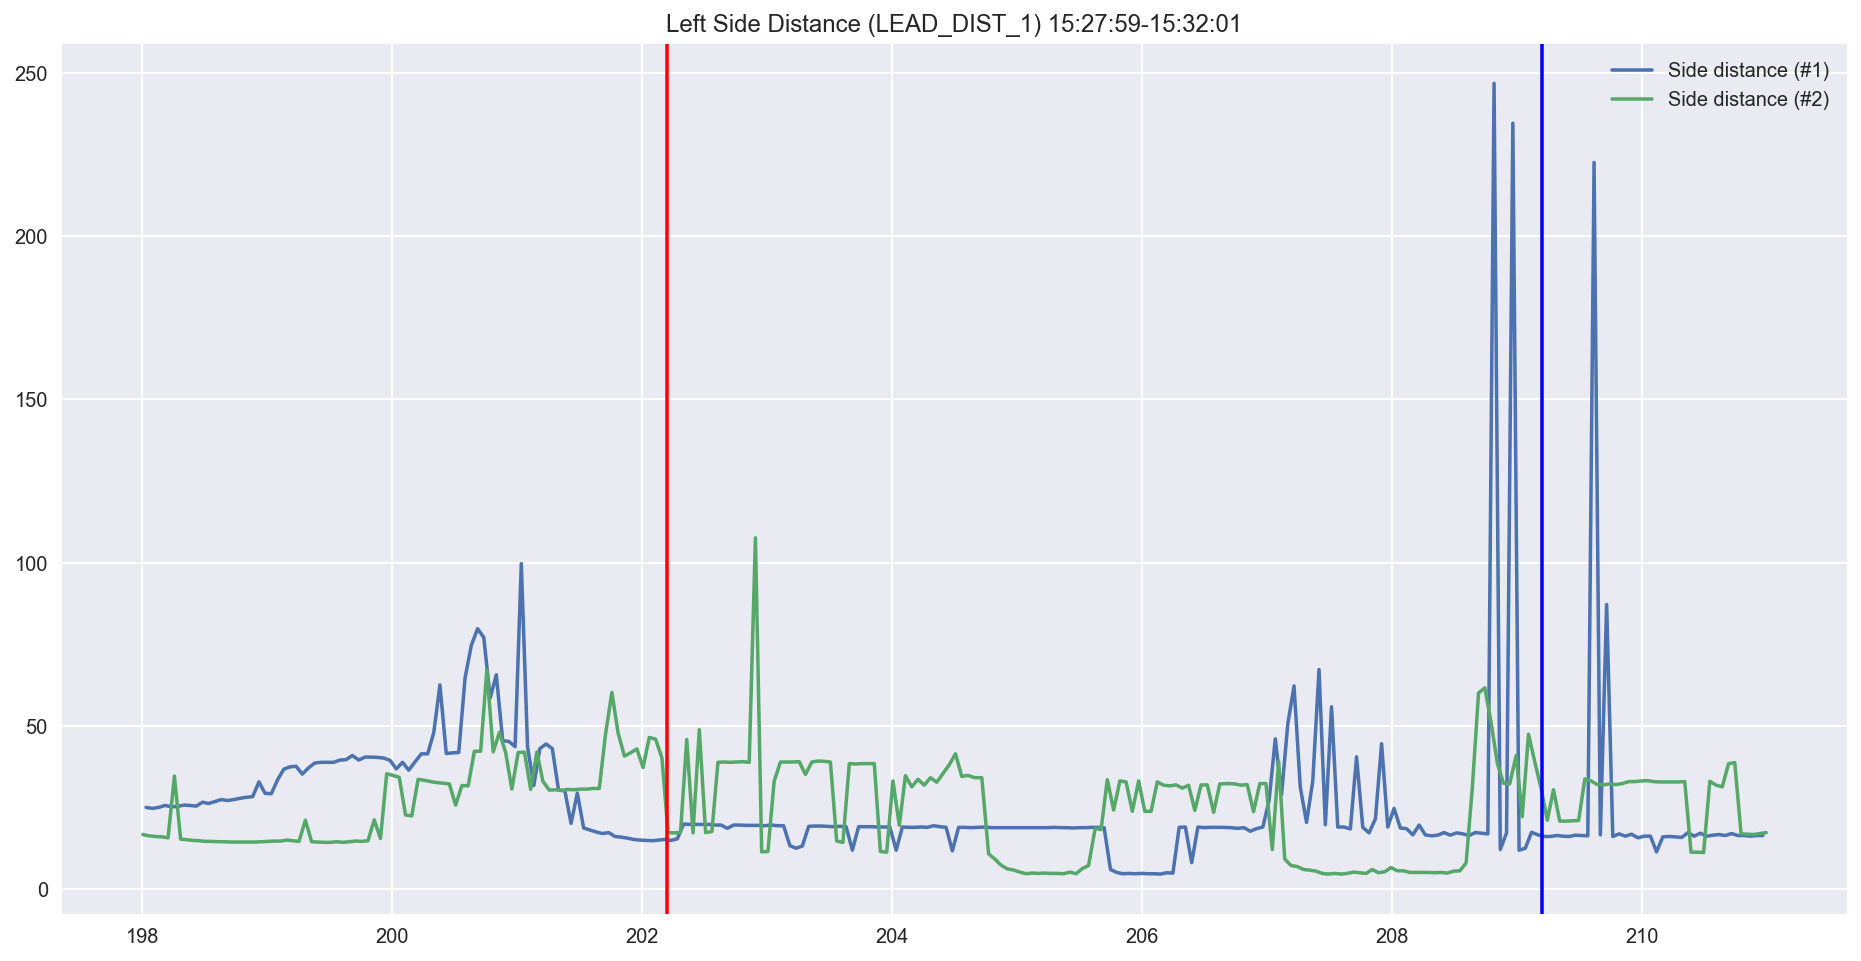

In [143]:
pass_number=2
dataframe_pass = getTimeWindow(dataframe_side,start_pass[pass_number]-3,end_pass[pass_number]+3)
side_1 = s.convertData('RADAR_SENSOR1','LEAD_DIST1',dataframe_pass,db)
pt.plot(side_1.Time-start,side_1.Message,label='Side distance (#1)')

side_2 = s.convertData('RADAR_SENSOR2','LEAD_DIST1',dataframe_pass,db)
pt.plot(side_2.Time-start,side_2.Message,label='Side distance (#2)')

pt.title('Left Side Distance (LEAD_DIST_1) ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), [start_pass[pass_number]], [end_pass[pass_number]], [], 
              fudgeFactor=videoFudgeFactor, relativeTime=start)


